## ML Model for Sentiment Analysis of tweets (Elon Mush) - Part 1

 - prepared by Nixon Chan

<b>*The following code are built on DataBrick and now converted to .ipynb format for displaying on GitHub. Therefore, those code will not work under Jupyter notebook.
    
<p>Due to restriction on Databrick, the original .dbc file cannot be converted into 1 .ipynb file. So, it was separated into 3 parts. </b>

This is a personal experimental project which try to predict the sentiment of each tweet collected from S3 bucket. The tweets collected is a plain tweet without label. First of all, each tweets will be  assigned a label to each tweet using simple method like textblob. Afterwards, EDA (exploratory data analysis) and data cleaning was conducted and pipelines built for feature engineering and model training.  


- Objective 
  - Define problem
- Data Processing
  - Data Collection (Load from WeCloudData S3 Bucket)
  - Label Creation using texblob
  - EDA (Exploratory data analysis)
  - Data Cleaning
    - Remove Duplicate record
    - Drop null tweet
- Feature Engineering
  - Stop Word Removal
  - Custom Word Removal
  - Lemmitization
  - Stemming
  - CounterVectortizer
  - ngram
  - IDF
  - VectorAssembler
Feature Selection
  - ChiSqSelector
- Model Training
  - Logistic Regression
  - Random Forest
Model Evalation
  - Accuracy
  - Confusion Matrix
  - Classification Report

## Objective - Predict the sentiment of collected tweets and the sentiment should be either postive, neutral or negative

## Data Processing


### Data Collection

In [0]:
# Define a function for mounting the S3 bucket

def mount_s3_bucket(access_key, secret_key, bucket_name, mount_folder):
  ACCESS_KEY_ID = access_key
  SECRET_ACCESS_KEY = secret_key
  ENCODED_SECRET_KEY = SECRET_ACCESS_KEY.replace("/", "%2F")

  print ("Mounting", bucket_name)

  try:
    # Unmount the data in case it was already mounted.
    dbutils.fs.unmount("/mnt/%s" % mount_folder)
    
  except:
    # If it fails to unmount it most likely wasn't mounted in the first place
    print ("Directory not unmounted: ", mount_folder)
    
  finally:
    # Lastly, mount our bucket.
    dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY_ID, ENCODED_SECRET_KEY, bucket_name), "/mnt/%s" % mount_folder)
    #dbutils.fs.mount("s3a://"+ ACCESS_KEY_ID + ":" + ENCODED_SECRET_KEY + "@" + bucket_name, mount_folder)
    print ("The bucket", bucket_name, "was mounted to", mount_folder, "\n")

In [0]:
# Mount S3 bucket to collect tweets for processing

# Set AWS programmatic access credentials
ACCESS_KEY = "YOUR_ACCESS_KEY"
SECRET_ACCESS_KEY = "YOUR_SECRET_ACCESS_KEY"

mount_s3_bucket(ACCESS_KEY, SECRET_ACCESS_KEY, 'weclouddata/twitter/', "twitter_ds")

Mounting weclouddata/twitter/
/mnt/twitter_ds has been unmounted.
The bucket weclouddata/twitter/ was mounted to twitter_ds 



In [0]:
# Mount my S3 to output the record and result 

mount_s3_bucket(ACCESS_KEY, SECRET_ACCESS_KEY, 'b19-bucket1/demo/', "demo")

Mounting b19-bucket1/demo/
/mnt/demo has been unmounted.
The bucket b19-bucket1/demo/ was mounted to demo 



In [0]:
# Create a spark Context
from pyspark.sql import SparkSession
spark = (SparkSession
.builder
.appName('Sentiment Analysis')
.config("spark.sql.legacy.timeParserPolicy", "LEGACY")
.getOrCreate())

sc = spark.sparkContext

In [0]:
# Read in all file inside the folder which was stored and organized in year, month, date and hour folders

twFile = '/mnt/twitter_ds/ElonMusk/*/*/*/*/*'

from pyspark.sql.types import StructType, StructField, IntegerType, LongType, FloatType, StringType

# Define the data structure
twSchema = StructType([
    StructField("id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("tweet", StringType(), True),
    StructField("followers_count", IntegerType(), True),
    StructField("location", StringType(), True),
    StructField("geo", StringType(), True),
    StructField("created_at", StringType(), True)]
)

# Read in all files
tweets = (spark.read
    .option("header", "false")
    .option("delimiter", "\t")
    .schema(twSchema)
    .csv(twFile)
)

### Label Creation using texblob

In [0]:
# Make use of textblob to determine its label

from pyspark.sql.functions import udf
from textblob import TextBlob

def analyze_sentiment(text):
    if text is None:
        return 0  # or any default sentiment you prefer for None values
    elif not isinstance(text, str):
        return 0  # or handle other non-string types
    else:
        blob = TextBlob(text)
        sentiment = blob.sentiment.polarity
        if sentiment > 0:
            return 1
        elif sentiment < 0:
            return -1
        else:
            return 0

# Register the UDF
sentiment_udf = udf(analyze_sentiment, IntegerType())

# Apply the UDF to create a new column "sentiment"
tweets = tweets.withColumn("label", sentiment_udf(tweets["tweet"]))

# Show the result
tweets.show(truncate=True)
display(tweets.count())

+-------------------+--------------------+---------------+--------------------+---------------+--------------------+----+--------------------+-----+
|                 id|                name|       username|               tweet|followers_count|            location| geo|          created_at|label|
+-------------------+--------------------+---------------+--------------------+---------------+--------------------+----+--------------------+-----+
|1594755513945755648|        J.E. Dyer ☘️|  OptimisticCon|Keep in mind, "Tr...|           9016|                None|None|Mon Nov 21 18:11:...|    0|
|1594755515485143052|      Javier Perdomo|  Javierperdomo|RT @MattGertz: El...|            469|                None|None|Mon Nov 21 18:11:...|    0|
|1594755517574164481|       Casey Reilley|   caseyreilley|RT @MattGertz: El...|            180|         Hawaii, USA|None|Mon Nov 21 18:11:...|    0|
|1594755519868043264|         Val Ornelas|   _surfcowgirl|RT @elizableu: I’...|            195|           

### EDA (Exploratory Data Analysis)

In [0]:
tweets.count()

Out[11]: 328766

In [0]:
# No of tweet is 328,766

In [0]:
tweets.show(10, truncate =False)

+-------------------+--------------------------------------------+---------------+------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------------------+----+------------------------------+-----+
|id                 |name                                        |username       |tweet                                                                                                                                           |followers_count|location             |geo |created_at                    |label|
+-------------------+--------------------------------------------+---------------+------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------------------+----+------------------------------+-----+
|1594755513945755648|J.E. Dyer ☘️                                |Optimistic

In [0]:
# Check if there is any null tweet

from pyspark.sql.functions import col
(tweets.filter(col('tweet').isNull())
    .count()   
)


Out[13]: 204

In [0]:
# 204 null records were found

In [0]:
# Check if there is any null label

(tweets.filter(col('label')
    .isNull())
    .count()
)

Out[14]: 0

In [0]:
# no null label was found

In [0]:
# Check the label distribution

(tweets.groupBy('label')
    .count()
    .sort('label', ascending=False)
    .show()
)

+-----+------+
|label| count|
+-----+------+
|    1|124397|
|    0|138531|
|   -1| 65838|
+-----+------+



In [0]:
# After labeling with Textblob, 124397 positive, 138531 netural and 65838 negative was found. 

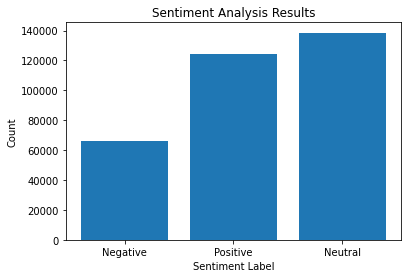

In [0]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
import pandas as pd

# Group by 'label' and count occurrences
result_df = tweets.groupBy('label').count()

# Map numerical labels to corresponding sentiment labels
result_df = result_df.withColumn('sentiment',
                                when(col('label') == 1, 'Positive')
                                .when(col('label') == 0, 'Neutral')
                                .when(col('label') == -1, 'Negative')
                                .otherwise('Unknown'))  # Default for other labels

# Convert the result to a Pandas DataFrame
pandas_df = result_df.toPandas()

# Plot the data using matplotlib
plt.bar(pandas_df['sentiment'], pandas_df['count'])
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')
plt.show()

Neutal with the highest frequency, Postive is the second highest and negative is the lowest

In [0]:
import plotly.express as px
from pyspark.sql.functions import when, col

# Map numerical labels to corresponding sentiment labels
tweets2 = tweets.withColumn('sentiment',
                   when(col('label') == 1, 'Positive')
                   .when(col('label') == 0, 'Neutral')
                   .when(col('label') == -1, 'Negative'))

# Convert the result to a Pandas DataFrame
pandas_df = tweets2.toPandas()

fig = px.pie(pandas_df, names='sentiment', title='Pie chart of different sentiments')
fig.show()

Positive, neutral and negative sentiment occupy 31.0%, 19.2% and 49.8% respectively.  

<b>*The pie chart cannot be properly displayed after conversion from dbc

### Data Cleaning and Preprocessing

In [ ]:
import pyspark.sql.functions as F

# Remove duplicated tweet
tweets_clean = tweets.dropDuplicates(['tweet'])

# Remove all hyperlink, non alphabet character, addition space
# Convert all character to lower cases
# Remove all leading and trailing spaces
tweets_clean = tweets_clean.withColumn('tweet', F.regexp_replace('tweet', r"http\S+", "")) \
                    .withColumn('tweet', F.regexp_replace('tweet', r"[^a-zA-z]", " ")) \
                    .withColumn('tweet', F.regexp_replace('tweet', r"\s+", " ")) \
                    .withColumn('tweet', F.lower('tweet')) \
                    .withColumn('tweet', F.trim('tweet')) 
                    
# Remove all null tweets
tweets_clean = tweets_clean.dropna(subset=['tweet'])

# Show the result and record count after cleaning
display(tweets_clean)
display(tweets_clean.count())